In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from torchmetrics.image.fid import FrechetInceptionDistance

from dataclasses import dataclass

In [2]:
device = "mps"

In [3]:
class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)

class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)

class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        out,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            elif upsampling_layer > num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens // 2, out)
            else:
                raise ValueError(
                    f"Invalid upsampling layer: {upsampling_layer}. In Encoder."
                )

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return F.sigmoid(x_recon)

class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay**self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average

class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3**0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x**2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts**2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], x.shape[2], x.shape[3]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )

class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
            out_channels,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = (
            self.quantize(x)
        )
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
            "encoding_indices": encoding_indices,
        }

class VQVAE_Trainer(pl.LightningModule):
    def __init__(
        self,
        sample_size=128,
        in_channels=3,
        out_channels=3,
        num_hiddens=64,
        num_downsampling_layers=2,
        num_residual_layers=4,
        num_residual_hiddens=128,
        embedding_dim=32,  # 32, 64, 128, 256
        num_embeddings=2048,  # 256, 512, 1024, 2048
        use_ema=True,
        decay=0.99,
        epsilon=1e-5,
        beta=0.25,
        lr=4e-4,
        weight_decay=0.01,
        fid_features=2048,
        batch_size=64,
        dataset="celeba_hq",
    ):
        super(VQVAE_Trainer, self).__init__()
        self.model = VQVAE(
            in_channels=in_channels,
            out_channels=out_channels,
            num_hiddens=num_hiddens,
            num_downsampling_layers=num_downsampling_layers,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            embedding_dim=embedding_dim,
            num_embeddings=num_embeddings,
            use_ema=use_ema,
            decay=decay,
            epsilon=epsilon,
        )

        self.beta = beta
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)
        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("train_dictionary_loss", out["dictionary_loss"])

        self.log("train_loss", loss)
        self.log("train_recon_error", recon_error)
        self.log("train_commitment_loss", out["commitment_loss"])

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("val_dictionary_loss", out["dictionary_loss"])

        self.log("val_loss", loss)
        self.log("val_recon_error", recon_error)
        self.log("val_commitment_loss", out["commitment_loss"])

        if batch_idx == 0:
            if self.global_step == 0 and batch_idx == 0:
                self.logger.experiment.log(
                    {
                        "original": wandb.Image(
                            torchvision.utils.make_grid(x[:64], nrow=8),
                            caption="Real Image",
                        )
                    }
                )

            self.logger.experiment.log(
                {
                    "reconstructed": wandb.Image(
                        torchvision.utils.make_grid(out["x_recon"][:64], nrow=8),
                        caption=f"Step {self.global_step}",
                    )
                }
            )

    def on_test_start(self):
        self.fid = FrechetInceptionDistance(self.hparams.fid_features).cpu()

    def test_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        # Resize to 299x299
        x = F.interpolate(x, size=299)
        x_hat = F.interpolate(out["x_recon"], size=299)

        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            x_hat = x_hat.repeat(1, 3, 1, 1)

        # Convert to uint8
        x = (x * 255).to(torch.uint8).cpu()
        x_hat = (x_hat * 255).to(torch.uint8).cpu()

        # Compute FID
        self.fid.update(x, real=True)
        self.fid.update(x_hat, real=False)

        fid_score = self.fid.compute()
        self.log("fid_score", fid_score)

    def configure_optimizers(self):
        return optim.AdamW(
            self.model.parameters(),
            lr=self.hparams.lr,
            amsgrad=True,
            weight_decay=self.hparams.weight_decay,
        )

    def train_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    (
                        torchvision.transforms.Grayscale()
                        if self.hparams.in_channels == 1
                        else torchvision.transforms.Lambda(lambda x: x)
                    ),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/train", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def val_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def test_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 4))

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )


In [4]:
vqvae = VQVAE_Trainer.load_from_checkpoint("blog/10-vqvae/vqvae/mnist-32/model.ckpt")
vqvae = vqvae.model.to(device)

print("Codebook shape:", vqvae.vq.e_i_ts.shape)

Codebook shape: torch.Size([4, 16])
 torch.Size([4, 16])


In [5]:
train_loader = torch.utils.data.DataLoader(
    torch.load("blog/10-vqvae/datasets/idx/mnist/train.pt"),
    batch_size=64,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

val_loader = torch.utils.data.DataLoader(
    torch.load("blog/10-vqvae/datasets/idx/mnist/val.pt"),
    batch_size=128,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [64]:
@dataclass
class GPTConfig:
    vocab_size: int = 32
    block_size: int = 65
    emb_size: int = 24
    heads: int = 12
    num_layers: int = 4
    attn_dropout: float = 0.1
    ff_mult: int = 4
    ff_dropout: float = 0.1


class AttentionHead(nn.Module):
    def __init__(self, config: GPTConfig, layer_idx, head_idx, cache_enabled=False):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_idx = head_idx
        self.cache_enabled = cache_enabled
        self.cache = {}

        self.q = nn.Linear(config.emb_size, config.emb_size)
        self.k = nn.Linear(config.emb_size, config.emb_size)
        self.v = nn.Linear(config.emb_size, config.emb_size)

        self.out = nn.Linear(config.emb_size, config.emb_size)

        self.attn_dropout = nn.Dropout(config.attn_dropout)

    def forward(self, x, mask=None):
        B, T, C = x.size()
        cache_key = (B, T, C)  # Example key; adjust based on your caching strategy

        if self.cache_enabled and cache_key in self.cache:
            k, v = self.cache[cache_key]["k"], self.cache[cache_key]["v"]
        else:
            k = (
                self.k(x)
                .view(B, T, self.config.heads, C // self.config.heads)
                .transpose(1, 2)
            )
            v = (
                self.v(x)
                .view(B, T, self.config.heads, C // self.config.heads)
                .transpose(1, 2)
            )
            if self.cache_enabled:
                self.cache[cache_key] = {"k": k, "v": v}

        q = (
            self.q(x)
            .view(B, T, self.config.heads, C // self.config.heads)
            .transpose(1, 2)
        )

        attn = (q @ k.transpose(-2, -1)) / ((C // self.config.heads) ** 0.5)

        if mask is not None:
            attn = attn.masked_fill(mask == 1, float("-inf"))

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).contiguous().view(B, T, C)

        return self.out(x), attn


class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, config: GPTConfig, layer_idx):
        super().__init__()
        self.config = config

        self.heads = nn.ModuleList(
            [
                AttentionHead(config, layer_idx=layer_idx, head_idx=i)
                for i in range(config.heads)
            ]
        )

    def forward(self, x, mask=None):
        # input and output are the same size
        attns = []
        for head in self.heads:
            attn, _ = head(x, mask=mask)
            attns.append(attn)

        return torch.mean(torch.stack(attns), dim=0)


class Block(nn.Module):
    def __init__(self, config: GPTConfig, layer_idx):
        super().__init__()
        self.config = config

        self.ln1 = nn.LayerNorm(config.emb_size)
        self.attn = MaskedMultiHeadAttention(config, layer_idx)

        self.ln2 = nn.LayerNorm(config.emb_size)
        self.ff = nn.Sequential(
            nn.Linear(config.emb_size, config.ff_mult * config.emb_size),
            nn.GELU(),
            nn.Linear(config.ff_mult * config.emb_size, config.emb_size),
        )

        if config.ff_dropout > 0:
            self.ff_dropout = nn.Dropout(config.ff_dropout)

        if config.attn_dropout > 0:
            self.attn_dropout = nn.Dropout(config.attn_dropout)

    def forward(self, x, mask=None):
        B, T, C = x.size()

        identity = x
        x = self.ln1(x)
        x = self.attn(x, mask=mask)

        if hasattr(self, "attn_dropout"):
            x = self.attn_dropout(x)

        x = x + identity

        identity = x
        x = self.ln2(x)
        x = self.ff(x)

        if hasattr(self, "ff_dropout"):
            x = self.ff_dropout(x)

        return x + identity


class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.token_emb = nn.Embedding(config.vocab_size, config.emb_size)
        self.pe = nn.Parameter(torch.randn(config.block_size, config.emb_size))

        self.blocks = nn.ModuleList(
            [Block(config, layer_idx=i) for i in range(config.num_layers)]
        )

        self.ln = nn.LayerNorm(config.emb_size)
        self.head = nn.Linear(config.emb_size, config.vocab_size, bias=False)

        # tie weights
        self.head.weight = self.token_emb.weight

        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, std=0.02)
            
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)

        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        B, T = x.size()
        assert (
            not T > self.config.block_size
        ), "Sequence length is longer than block size"

        emb = self.token_emb(x)
        pe = self.pe[:T].unsqueeze(0)
        mask = torch.triu(torch.ones(T, T, device=x.device), 1).bool()

        x = emb + pe

        for block in self.blocks:
            x = block(x, mask=mask)

        x = self.ln(x)
        return self.head(x)

    def loss(self, y, y_pred):
        # Input is a contiguous tensor
        y = y.flatten()
        y_pred = y_pred.view(-1, y_pred.size(-1))

        return F.cross_entropy(y_pred, y)

    def get_param_count(self):
        return sum(p.numel() for p in self.parameters())

    @torch.no_grad()
    def generate(
        self,
        class_label: int | None = None,
        max_len: int = 64,
        temperature: float = 1.0,
        top_k: int = 16,
    ):
        self.eval()

        if class_label is not None:
            generated = []
            primer_t = torch.as_tensor(class_label, device=device).view(1, -1)

        else:
            classes = torch.arange(10, device=device).view(-1, 1)
            generated = []
            primer_t = classes

        for _ in range(max_len):
            if primer_t.size(1) >= self.config.block_size:
                primer_t = primer_t[:, -self.config.block_size :]

            out = self(primer_t)
            out = out[:, -1, :] / temperature
            out = F.softmax(out, dim=-1)
            out = torch.topk(out, top_k, dim=-1)[0]
            out = torch.multinomial(out, num_samples=1)

            gen = out

            generated.append(gen)

            primer_t = torch.cat((primer_t, out), dim=1)

        return torch.cat(generated, dim=1)


config = GPTConfig()
model = GPT(config).to(device)
num_train_steps = 0

print(f"Model has {model.get_param_count():,} parameters")

Model has 136,872 parameters



In [68]:
import matplotlib.pyplot as plt
@torch.no_grad()
def decode_idxs(idxs):
    idxs = idxs.to(device)
    quantized_x = F.embedding(
        idxs.view(idxs.shape[0], 8, 8), vqvae.vq.e_i_ts.transpose(0, 1)
    ).permute(0, 3, 1, 2)

    # reconstruct
    x_recon = vqvae.decoder(quantized_x)

    plt.figure(figsize=(10, 10))
    plt.imshow(torchvision.utils.make_grid(x_recon[:64], nrow=10).cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.show()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    for x, y in tqdm.tqdm(val_loader):
        y = y.to("mps")
        x = x.to("mps") + 10

        x = torch.cat([y.view(-1, 1), x], dim=1)

        inputs = x[:, :-1]
        targets = x[:, 1:]

        outputs = model(inputs)
        loss = model.loss(targets, outputs)

        total_loss += loss.item()

    return total_loss / len(loader)

In [69]:
from ema_pytorch import EMA

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
ema = EMA(model, beta=0.999, update_after_step=100, update_every=10)

In [84]:
epochs = 20
for epoch in range(20):
    val_loss = evaluate(model, val_loader)
    scheduler.step(val_loss)

    model.train()
    pbar = tqdm.tqdm(train_loader, leave=False, desc="Epoch: %d" % (epoch + 1))
    for x, y in pbar:
        y = y.to(device)
        x = x.to(device) + 10

        x = torch.cat([y.view(-1, 1), x], dim=1)

        inputs = x[:, :-1]
        targets = x[:, 1:]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = model.loss(targets, outputs)

        loss.backward()
        optimizer.step()

        ema.update()

        pbar.set_postfix(loss=loss.item(), lr=str(scheduler._last_lr[0]).format("2e"), val_loss=val_loss)

 43%|████▎     | 34/79 [00:11<00:14,  3.03it/s]


KeyboardInterrupt: 

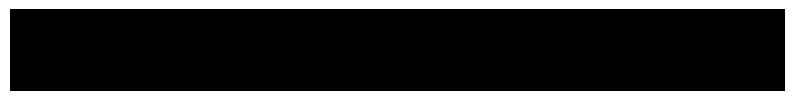

In [83]:
model.eval()
decode_idxs(model.generate(temperature=0, top_k=32))

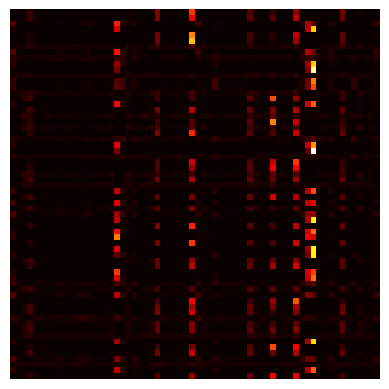

In [93]:
# visualize attention head
attn_head = model.blocks[0].attn.heads[0]

x, y = next(iter(val_loader))
x, y = x.to(device), y.to(device)
x = torch.cat([y.view(-1, 1), x], dim=1)

inputs = x[:, :-1]

inputs = model.token_emb(inputs)
inputs = inputs + model.pe[:inputs.size(1)]
inputs = model.blocks[0].ln1(inputs)

attn = attn_head(inputs, mask=None)[1].detach()
plt.imshow(attn[0, 0].cpu().numpy(), cmap="hot", interpolation="nearest")
plt.axis("off")
plt.show()

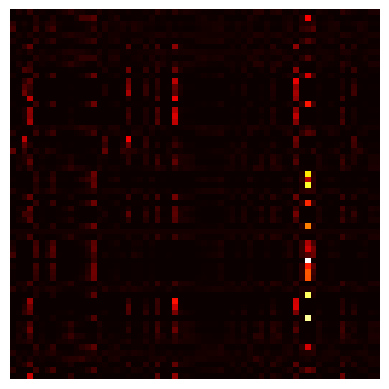

In [96]:
plt.imshow(attn[0, 3].cpu().numpy(), cmap="hot", interpolation="nearest")
plt.axis("off")
plt.show()